In [1]:
# data wrangling and linear algebra
import pandas as pd
import numpy as np
import pandas_ta as ta

# data visualisation
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import matplotlib

# metrics
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

# yahoo finance api
import yfinance as yf

# statistical tests
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller

# framework
import tensorflow as tf
from tensorflow.keras import layers, models

# misc
import warnings
import os


warnings.filterwarnings(action='ignore')
pd.set_option('display.max_rows',500)
matplotlib.rcParams['figure.figsize']  = (12,8)

In [2]:
# get microsoft stock data
stock = yf.Ticker('NFLX')

# get stock info
stock.info

{'zip': '95032',
 'sector': 'Communication Services',
 'fullTimeEmployees': 8600,
 'longBusinessSummary': 'Netflix, Inc. provides subscription streaming entertainment service. It offers TV series, documentaries, and feature films across various genres and languages. The company provides members the ability to receive streaming content through a host of Internet-connected screens, including TVs, digital video players, television set-top boxes, and mobile devices. It also provides DVDs-by-mail membership services. The company has approximately 167 million paid members in 190 countries. Netflix, Inc. was founded in 1997 and is headquartered in Los Gatos, California.',
 'city': 'Los Gatos',
 'phone': '408-540-3700',
 'country': 'United States',
 'companyOfficers': [],
 'website': 'http://www.netflix.com',
 'maxAge': 1,
 'address1': '100 Winchester Circle',
 'industry': 'Entertainment',
 'previousClose': 481.33,
 'regularMarketOpen': 482.82,
 'twoHundredDayAverage': 419.76978,
 'trailingAnn

In [191]:
# get historical market data
hist = stock.history(start = '2010-08-01', end = '2020-07-31', period = '1d')
hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2010-08-02,14.86,15.00,14.42,14.55,24295600,0,0.0
2010-08-03,14.44,14.96,14.10,14.92,30139200,0,0.0
2010-08-04,15.00,15.50,14.96,15.45,24243100,0,0.0
2010-08-05,15.32,15.81,15.07,15.79,24296300,0,0.0
2010-08-06,15.53,16.96,15.41,16.90,48693400,0,0.0
...,...,...,...,...,...,...,...
2020-07-24,468.77,487.17,467.54,480.45,7746200,0,0.0
2020-07-27,484.51,496.92,482.31,495.65,7863100,0,0.0
2020-07-28,496.02,497.79,487.76,488.51,5986700,0,0.0


In [192]:
# droppping stock splits and dividends
hist.drop(['Dividends', 'Stock Splits'], axis = 1, inplace=True)
hist.columns =  ['open', 'high', 'low', 'close', 'volume']

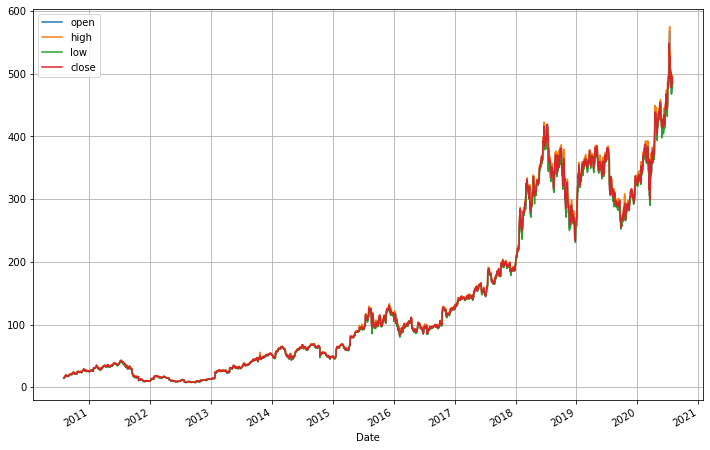

In [193]:
hist.drop('volume', axis = 1).plot(grid = True)
plt.show()

def get_features(df):  
    """
    Calculates technical indicators:
    20 SMA, 20 EMA, RSI, MACD, CCI, BOLLINDER BANDA
    """    
    df.ta.sma(20, append = True)
    df.ta.ema(20, append = True)
    df.ta.rsi(length = 20, append = True)
    df.ta.macd(append = True)
    df.ta.cci(append = True)
    df.ta.bbands(append = True)
    
    return df.dropna()
    

hist = get_features(hist)
hist.head()

In [194]:
def split_data(df, split_time):
    split_index = len(hist.loc[hist.index < split_time])
    train_data = hist.iloc[:split_index]
    val_data = hist.iloc[split_index:]
    
    return split_index, train_data, val_data

split_index, train_data, val_data = split_data(hist, '2019-01-01')

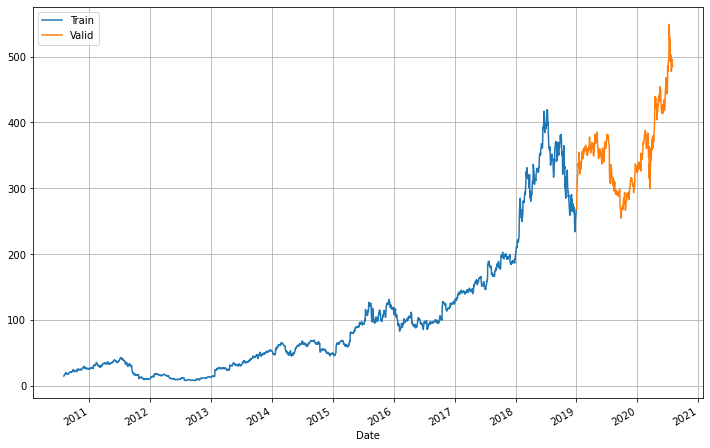

In [195]:
pd.concat([train_data['close'], val_data['close']], axis = 1).plot(grid = True)
plt.legend(['Train', 'Valid'])
plt.show()

In [196]:
def normalise_window_data(data, window_size = 50):
    data = data.copy()
    norm_data = []
    
    for time in range(len(data)-window_size):
        window_data = data.iloc[time:time+window_size,:]
        normalised_window = []
        for col in range(data.shape[1]):
            norm_col = ((window_data.iloc[:,col]/window_data.iloc[0,col])-1).values
            normalised_window.append(norm_col)
        normalised_window = np.array(normalised_window).T
        norm_data.append(normalised_window)
    
    norm_data = np.array(norm_data)    
    return norm_data

In [11]:
"""def normalise_window_data(data, window_size = 50):
    data = data.copy()
    norm_data = []
    
    for time in range(len(data)-window_size):
        window_data = data.values[time:time+window_size,:]
        normalised_window = []
        for col in range(data.shape[1]):
            norm_col = [((float(p)/float(window_data[0,col]))-1) for p in window_data[:,col]]
            normalised_window.append(norm_col)
        normalised_window = np.array(normalised_window).T
        norm_data.append(normalised_window)
    
    norm_data = np.array(norm_data)    
    return norm_data"""

'def normalise_window_data(data, window_size = 50):\n    data = data.copy()\n    norm_data = []\n    \n    for time in range(len(data)-window_size):\n        window_data = data.values[time:time+window_size,:]\n        normalised_window = []\n        for col in range(data.shape[1]):\n            norm_col = [((float(p)/float(window_data[0,col]))-1) for p in window_data[:,col]]\n            normalised_window.append(norm_col)\n        normalised_window = np.array(normalised_window).T\n        norm_data.append(normalised_window)\n    \n    norm_data = np.array(norm_data)    \n    return norm_data'

In [197]:
def create_dataset(series, window_size, batch_size, shuffle_buffer = 1000):
    
    """
    Creates windowed dataset, data from time step t:t+window_size is input X and the next value is output y
    
    :params series: the series for which dataset to be created (numpy array)
    :params window_size: window size of each input X
    :params batch_size: batch size for training
    :params shuffle_buffer: buffer parameter for shuffling the data in tf shuffle API
    
    returns generator object to generate input X, output y (arrays)
    """
    norm = normalise_window_data(train_data, window_size = window_size)
    
    dataset = tf.data.Dataset.from_tensor_slices(norm)
    dataset = dataset.map(lambda w: (w[:-1,:], w[-1,3]))
    dataset = dataset.shuffle(shuffle_buffer)    
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset


In [198]:
# params
window_size = 30
batch_size = 32
epochs = 100
shuffle_buffer = 1000

In [199]:
train_dataset = create_dataset(train_data, window_size, batch_size)
valid_dataset = create_dataset(val_data, window_size=window_size, batch_size=batch_size)

In [207]:
tf.keras.backend.clear_session()
# model architecture

# create model
model = models.Sequential([
    layers.LSTM(100, input_shape = [None, train_data.shape[-1]], return_sequences = True),
    layers.Dropout(0.5),    
    layers.LSTM(100, return_sequences = True),
    layers.Dropout(0.3),
    layers.LSTM(100, return_sequences = True),
    layers.Dropout(0.3),
    layers.LSTM(100),
    layers.Dropout(0.3),
    layers.Dense(100, activation = 'relu'), 
    layers.Dropout(0.3),
    layers.Dense(50, activation = 'relu'),           
    layers.Dense(1, activation = 'relu')    
])

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(0.001, decay_steps = 100000, decay_rate = 0.9)

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)


model.compile(loss = 'mse', optimizer = optimizer)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 100)         42400     
_________________________________________________________________
dropout (Dropout)            (None, None, 100)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 100)         80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 100)         80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               8

In [208]:
history = model.fit(train_dataset, epochs = epochs, validation_data=valid_dataset) 

Epoch 1/100
66/66 [==============================] - 2s 29ms/step - loss: 0.0224 - val_loss: 0.0172
Epoch 2/100
66/66 [==============================] - 1s 14ms/step - loss: 0.0187 - val_loss: 0.0162
Epoch 3/100
66/66 [==============================] - 1s 15ms/step - loss: 0.0163 - val_loss: 0.0154
Epoch 4/100
66/66 [==============================] - 1s 15ms/step - loss: 0.0163 - val_loss: 0.0148
Epoch 5/100
66/66 [==============================] - 1s 15ms/step - loss: 0.0152 - val_loss: 0.0144
Epoch 6/100
66/66 [==============================] - 1s 15ms/step - loss: 0.0153 - val_loss: 0.0146
Epoch 7/100
66/66 [==============================] - 1s 15ms/step - loss: 0.0147 - val_loss: 0.0142
Epoch 8/100
66/66 [==============================] - 1s 20ms/step - loss: 0.0146 - val_loss: 0.0141
Epoch 9/100
66/66 [==============================] - 1s 14ms/step - loss: 0.0144 - val_loss: 0.0139
Epoch 10/100
66/66 [==============================] - 1s 14ms/step - loss: 0.0144 - val_loss: 0.0144

66/66 [==============================] - 1s 20ms/step - loss: 0.0129 - val_loss: 0.0126
Epoch 83/100
66/66 [==============================] - 2s 24ms/step - loss: 0.0129 - val_loss: 0.0126
Epoch 84/100
66/66 [==============================] - 1s 19ms/step - loss: 0.0128 - val_loss: 0.0126
Epoch 85/100
66/66 [==============================] - 1s 18ms/step - loss: 0.0129 - val_loss: 0.0126
Epoch 86/100
66/66 [==============================] - 1s 15ms/step - loss: 0.0128 - val_loss: 0.0126
Epoch 87/100
66/66 [==============================] - 1s 15ms/step - loss: 0.0128 - val_loss: 0.0125
Epoch 88/100
66/66 [==============================] - 1s 15ms/step - loss: 0.0128 - val_loss: 0.0125
Epoch 89/100
66/66 [==============================] - 1s 15ms/step - loss: 0.0129 - val_loss: 0.0126
Epoch 90/100
66/66 [==============================] - 1s 15ms/step - loss: 0.0131 - val_loss: 0.0125
Epoch 91/100
66/66 [==============================] - 1s 21ms/step - loss: 0.0128 - val_loss: 0.0125
Epo

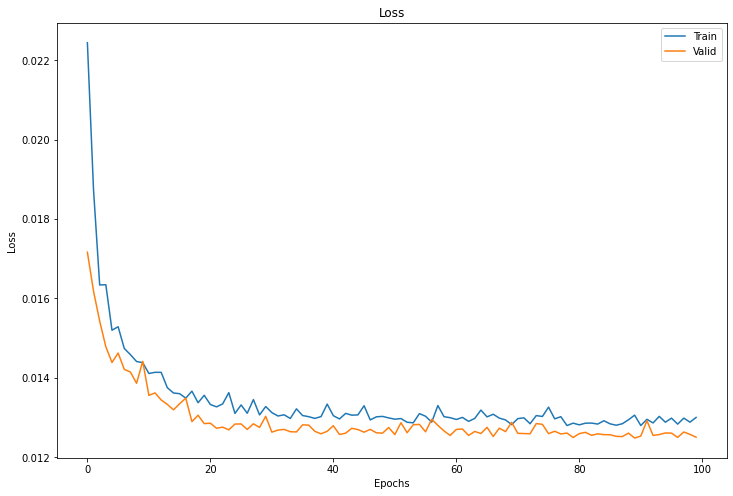

In [209]:
# plotting
plt.plot(history.history['loss'], label = 'Train')
plt.plot(history.history['val_loss'], label = 'Valid')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Code courtesy: https://github.com/jaungiers/LSTM-Neural-Network-for-Time-Series-Prediction/blob/master/core/data_processor.py

In [210]:
test_norm = normalise_window_data(val_data, window_size)
x_test, y_test = test_norm[:,:-1,:], test_norm[:,-1,[3]]

In [214]:
def get_multi_sequence_forecast(model, x_test, window_size, prediction_len = window_size):
    prediction_seq = []
    for i in range(round(len(x_test)/prediction_len)):
        curr_frame = x_test[i*prediction_len]
        
        predictions = []
        for j in range(prediction_len):
            predictions.append(model.predict(curr_frame[np.newaxis,:,:]))
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, window_size-2, predictions[-1], axis = 0)
            
        prediction_seq.append(predictions)

    return prediction_seq  
forecast = get_multi_sequence_forecast(model, x_test, window_size)

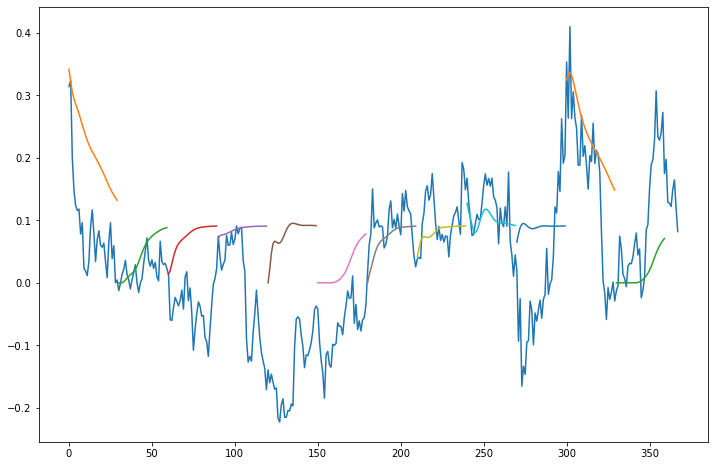

In [215]:
def plot_results_multiple(predicted_data, true_data, prediction_len = window_size):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plot_data = np.array(padding+data).flatten()
        plt.plot(plot_data, label='Prediction')
    plt.show()
plot_results_multiple(forecast, y_test)